# Пример использования библиотеки BigARTM для тематического моделирования
## Для Bigartm v0.8.0
### Редактировал Максим Чурилин

Импортируем BigARTM:

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline

In [5]:
import artm

Первое считывание данных (преобразуем удобный для человека формат в формат, который использует модель):

In [6]:
batch_vectorizer = artm.BatchVectorizer(data_path="school.txt", data_format="vowpal_wabbit", target_folder="school_batches", 
                                       batch_size=100)

В следующий раз данные можно считывать уже из батчей:

In [7]:
batch_vectorizer = artm.BatchVectorizer(data_path="school_batches", data_format='batches')

Создаем объект модели:

In [8]:
T = 10   # количество тем
model_artm = artm.ARTM(num_topics=T, topic_names=["sbj"+str(i) for i in range(T)], class_ids={"text":1}, 
                       num_document_passes=1, reuse_theta=True, cache_theta=True, seed=-1)
# число после названия модальностей - это их веса

Создаем словарь и инициализируем модель с его помощью

In [9]:
dictionary = artm.Dictionary('dictionary')
dictionary.gather(batch_vectorizer.data_path)

In [11]:
model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore',
                                           dictionary='dictionary'))
model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore', class_id="text"))
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_artm.scores.add(artm.TopTokensScore(name="top_words", num_tokens=15, class_id="text"))

In [12]:
model_artm.initialize('dictionary')

Строим модель. Offline - проходит по всей коллекции много раз. Удобно, когда коллекция маленькая.

In [13]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=40)

Необходимое число итераций можно отслеживать по графику перплексии. Когда она перестала меняться, модель сошлась.

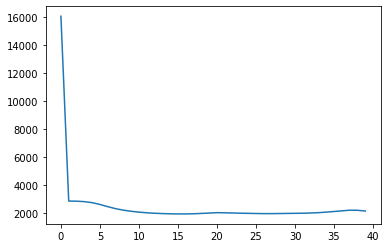

In [14]:
plt.plot(model_artm.score_tracker["PerplexityScore"].value)

Выведем топы слов:

In [17]:
for topic_name in model_artm.topic_names:
    print (topic_name + ': ',)
    tokens = model_artm.score_tracker["top_words"].last_tokens
    for word in tokens[topic_name]:    
        print (word, end=' ')
    print()

sbj0: 
который быть что это человек этот как свой для они его весь такой время себя 
sbj1: 
a множитель возведение b скобка x раскладывать умножение сокращенный разложение ответ квадрат слагаемое многочлен выражение 
sbj2: 
обособление куприн слово раскольников мастер роман словосочетание маргарита подчинительный соня оборот вера браслет старик сантьяго 
sbj3: 
который быть год свой время государство человек мир становиться жизнь северный первый война африка ребенок 
sbj4: 
x a b уравнение дробь квадратный y степень функция число f решение корень c пример 
sbj5: 
быть год пушкин функция свой его русский который поэт империя культура весь a f трение 
sbj6: 
сила быть тело энергия поле при магнитный точка географический наречие если частица например заряд величина 
sbj7: 
который что это как человек для этот такой быть являться мочь себя она его свой 
sbj8: 
который быть что это свой как этот человек для x они такой государство a весь 
sbj9: 
который быть что этот это как человек свой дл

Давайте посмотрим также на разреженность матриц:

In [18]:
print (model_artm.score_tracker["SparsityPhiScore"].last_value)
print (model_artm.score_tracker["SparsityThetaScore"].last_value)

0.7333064079284668
0.16533613204956055


В темах много общеупотребительных слов (так называемой, фоновой лексики). Чтобы этого избежать, будем использовать разреживающий регуляризатор для матрицы фи. Он будет подавлять слова, которые имеют большую частоту во всей коллекции.

In [19]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-100, dictionary=dictionary))
#если вы хотите применять регуляризатор только к некоторым модальностям, указывайте это в параметре class_ids: class_ids=["text"]

In [20]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

In [41]:
for topic_name in model_artm.topic_names:
    print topic_name + ': ',
    tokens = model_artm.score_tracker["top_words"].last_tokens
    for word in tokens[topic_name]:    
        print word,
    print

sbj0:  право быть который человек ребенок язык они семья также это являться для свой время русский
sbj1:  что свой который быть это герой человек его этот она жизнь они ребенок как такой
sbj2:  предложение слово который что это например быть как сила или такой речь они этот если
sbj3:  который что ядро энергия это вода этот земля быть масса атом как температура такой океан
sbj4:  пушкин поэт который что стихотворение быть свой это звук этот год весь его лирика произведение
sbj5:  x быть a b число этот при функция уравнение что это для если ток который
sbj6:  человек который свой что жизнь его быть это герой как произведение литература этот для русский
sbj7:  который человек общество развитие социальный быть как это политический государство себя культура жизнь век для
sbj8:  страна государство население который быть территория этот год являться африка время что хозяйство также сша
sbj9:  быть который год государство война свой что становиться первый как весь военный время империя армия


In [42]:
print model_artm.score_tracker["SparsityPhiScore"].last_value
print model_artm.score_tracker["SparsityThetaScore"].last_value

0.801751661594
0.285084033613


Попробуем менять коэффициент регуляризации:

In [43]:
model_artm.regularizers['SparsePhi'].tau = -5*1e4

In [44]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

In [45]:
for topic_name in model_artm.topic_names:
    print topic_name + ': ',
    tokens = model_artm.score_tracker["top_words"].last_tokens
    for word in tokens[topic_name]:    
        print word,
    print

sbj0:  право язык свобода семья гражданин английский правовой религиозный гражданский суд порядок орган честь will is
sbj1:  ребенок лермонтов поэма сказка отец молодой хороший сюжет любить гоголь комедия ничто романтизм жена эпос
sbj2:  слово предложение например случай работа простой предмет какой речь глагол физика скорость свет кто угол
sbj3:  земля энергия вода ядро масса количество природный океан атом движение температура частица заряд море располагать
sbj4:  пушкин поэт стихотворение звук лирика писать стих поэзия русь былина почти любовный князь бумага сравнение
sbj5:  x при a число если b функция тело два получать можно уравнение равный пример корень
sbj6:  человек свой его жизнь герой русский произведение мир литература история сам автор литературный личность писатель
sbj7:  общество век развитие социальный политический отношение процесс форма экономический производство культура характер система понятие роль
sbj8:  государство страна территория население город северный миров

In [46]:
# еще раз посмотрим на разреженность
print model_artm.score_tracker["SparsityPhiScore"].last_value
print model_artm.score_tracker["SparsityThetaScore"].last_value

0.900080750357
0.331512605042


Обратите внимание, что разреживать модель рекомендуется только после того, как она сошлась без регуляризации.

Сохранение и загрузка модели:

In [ ]:
model_artm.save("my_model")

In [ ]:
model_artm.load("my_model")

Можно попросить матрицы в чистом виде:

In [47]:
phi = model_artm.get_phi()

In [48]:
phi

,sbj0,sbj1,sbj2,sbj3,sbj4,sbj5,sbj6,sbj7,sbj8,sbj9
домохозяйка,0.00000,0.000000,0.000123,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
институт,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002557,0.000000,0.000000
машинка,0.00000,0.000000,0.000000,0.000000,0.000257,0.000000,0.000000,0.000000,0.000000,0.000000
прочий,0.00000,0.001465,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
навязнуть,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000102,0.000000,0.000000,0.000000
физиология,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000247,0.000000,0.000000
истязать,0.00024,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
выборы,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000995
кндр,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000280,0.000000
федерализм,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000093,0.000000


Матрица вероятностей тем в документах.

In [50]:
theta = model_artm.get_theta()
theta

,201,202,203,204,205,206,207,208,209,210,...,91,92,93,94,95,96,97,98,99,100
sbj0,0.000000,0.0,0.000000,0.025641,0.0,0.005495,1.282051e-02,0.007012,0.015306,0.016878,...,0.0,0.000000,0.000000,0.000000,0.004566,0.000000,0.000000,1.065346e-16,0.009944,0.020492
sbj1,0.004695,0.0,0.000000,0.005128,0.0,0.000000,2.326925e-09,0.071799,0.025636,0.025316,...,0.0,0.000000,0.000000,0.013393,0.305687,0.000000,0.309735,7.356615e-03,0.066667,0.479444
sbj2,0.061033,0.0,0.027053,0.035897,0.0,0.093407,4.273504e-02,0.041958,0.041297,0.017794,...,1.0,0.013451,0.341317,0.000000,0.000000,0.144444,0.017699,6.179777e-02,0.318133,0.049180
sbj3,0.652196,0.0,0.008969,0.020513,0.0,0.030890,2.564103e-02,0.017791,0.072254,0.000000,...,0.0,0.174107,0.000000,0.000000,0.000000,0.593818,0.000000,1.966293e-01,0.015045,0.000000
sbj4,0.000000,0.0,0.004484,0.000000,0.0,0.016905,9.110670e-03,0.020979,0.425943,0.000000,...,0.0,0.000000,0.000000,0.000000,0.013948,0.000000,0.022124,4.757892e-01,0.010018,0.000000
sbj5,0.282076,1.0,0.851805,0.046154,1.0,0.740760,7.264958e-02,0.061090,0.000000,0.039157,...,0.0,0.031250,0.658683,0.000000,0.000000,0.261737,0.017699,1.629214e-01,0.075431,0.000000
sbj6,0.000000,0.0,0.053812,0.148718,0.0,0.041114,2.173850e-01,0.160897,0.292013,0.063291,...,0.0,0.000000,0.000000,0.120536,0.602739,0.000000,0.314159,9.550567e-02,0.366667,0.286949
sbj7,0.000000,0.0,0.009034,0.497436,0.0,0.043956,8.974358e-02,0.499593,0.000000,0.042194,...,0.0,0.071429,0.000000,0.674107,0.073059,0.000000,0.106195,0.000000e+00,0.033333,0.073771
sbj8,0.000000,0.0,0.013453,0.148718,0.0,0.005495,2.905983e-01,0.000000,0.040816,0.315539,...,0.0,0.709763,0.000000,0.000000,0.000000,0.000000,0.048673,0.000000e+00,0.014286,0.000000
sbj9,0.000000,0.0,0.031390,0.071795,0.0,0.021978,2.393163e-01,0.118881,0.086735,0.479830,...,0.0,0.000000,0.000000,0.191964,0.000000,0.000000,0.163717,0.000000e+00,0.090476,0.090164


Если бы у нас были новые батчи, по которым мы не строим модель, а хотим только получить матрицу theta, можно пользоваться методом transform.

In [28]:
theta_test = model_artm.transform(batch_vectorizer)